In [1]:
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import xrft as xrft
from scipy.ndimage import gaussian_filter as gauss
import numpy as np
import sys
sys.path.append("/homes/metogra/iufarias/Documents/Scripts/useful")
import romspickle as rp
import seawater as sw
import pandas as pd
from dask.diagnostics import ProgressBar
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

plt.rcParams['font.size']=15
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['font.weight']='bold'

In [2]:
dx=2 #km for WRF

In [3]:

chunk={'time_counter':20}
path='/data/pacific/lrenault/SASI/FULL/WRF/'
listm=glob(path+'*DAY.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[-7:],chunks=chunk)


path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listt=glob(path+'*DAY.nc');listt.sort()
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[2:],chunks=chunk)

In [4]:
# sw.dist(lat=varf.nav_lat[:,-1],lon=varf.nav_lon[:,-1])[0]

In [5]:
def SMfield(var,g_sigma=None,time_str='time_centered'):
    from scipy.ndimage import gaussian_filter as gauss
    var_smoothed=var.copy()
    
    for ix in range(var[time_str].shape[0]):
        var_smoothed[ix]=gauss(var[ix].data,g_sigma)
    
    var_prime=var-var_smoothed
    return var_smoothed,var_prime

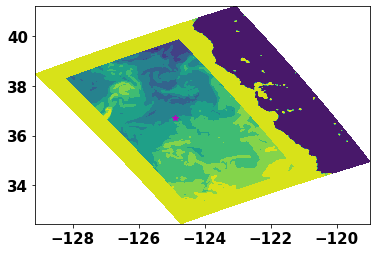

In [28]:
plt.figure()
plt.contourf(sst.nav_lon,sst.nav_lat,sst[0])
plt.contourf(sst.nav_lon[30:-30,30:200],sst.nav_lat[30:-30,30:200],sst[0,30:-30,30:200])
# plt.plot(sst.nav_lon[190,150],sst.nav_lat[190,150],'r*')
plt.plot(sst.nav_lon[210,110],sst.nav_lat[210,110],'m*')




## Submesoscale fluctuations

In [29]:
t2_f=varf.T2#[:,30:-30,30:200]
t2_t=vart.T2#[:,30:-30,30:200]

gnum=1.2
t2_fg,t2_fp=SMfield(t2_f,g_sigma=gnum)
t2_tg,t2_tp=SMfield(t2_t,g_sigma=gnum)




#### Test-Assessing Filter

/homes/metogra/iufarias/miniconda3/envs/ROMS/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/homes/metogra/iufarias/miniconda3/envs/ROMS/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/homes/metogra/iufarias/miniconda3/envs/ROMS/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
/homes/metogra/iufarias/miniconda3/envs/ROMS/lib/python3.7/site-packages/xrft/xrft.py:51: FutureWarning: Please provide the name of window adhering to scipy.signal.windows. The boolean option will be deprecated in future releases.
  FutureWarning,
findfont

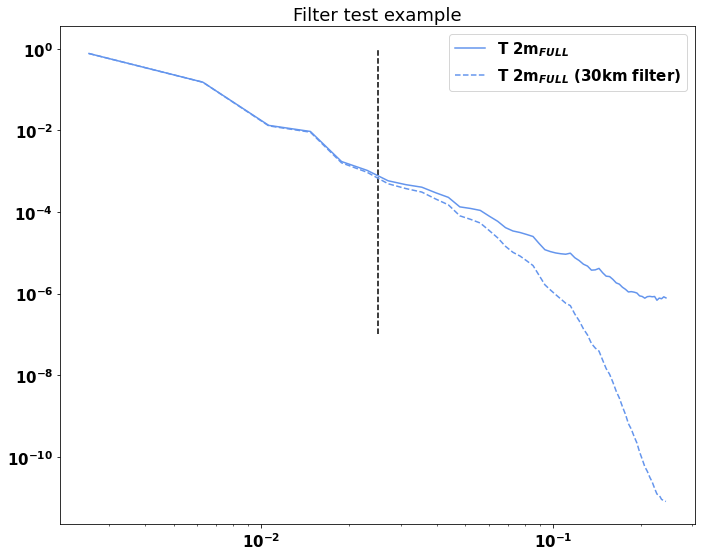

In [30]:

aa=xrft.isotropic_power_spectrum(t2_f[0,30:-30,30:200].drop(['nav_lat', 'nav_lon']),nfactor=2,truncate='True',detrend='linear', window=True)
bb=xrft.isotropic_power_spectrum(t2_fg[0,30:-30,30:200].drop(['nav_lat', 'nav_lon']),nfactor=2,truncate='True',detrend='linear', window=True)

cc=xrft.isotropic_power_spectrum(t2_t[0,30:-30,30:200].drop(['nav_lat', 'nav_lon']),nfactor=2,truncate='True',detrend='linear', window=True)
dd=xrft.isotropic_power_spectrum(t2_tg[0,30:-30,30:200].drop(['nav_lat', 'nav_lon']),nfactor=2,truncate='True',detrend='linear', window=True)

# aa=xrft.isotropic_power_spectrum(ske_f[0,30:-30,30:200].drop(['nav_lat', 'nav_lon']),nfactor=2,truncate='True',detrend='linear', window=True)
# bb=xrft.isotropic_power_spectrum(ske_fg[0,30:-30,30:200].drop(['nav_lat', 'nav_lon']),nfactor=2,truncate='True',detrend='linear', window=True)

# cc=xrft.isotropic_power_spectrum(ske_t[0,30:-30,30:200].drop(['nav_lat', 'nav_lon']),nfactor=2,truncate='True',detrend='linear', window=True)
# dd=xrft.isotropic_power_spectrum(ske_tg[0,30:-30,30:200].drop(['nav_lat', 'nav_lon']),nfactor=2,truncate='True',detrend='linear', window=True)



plt.figure(figsize=(10,8))
plt.plot([1/40,1/40],[1e-7,1],'k--')
# plt.plot([1/20,1/20],[1e-11,1e-2],'r--')

plt.title('Filter test example')

plt.plot(aa.freq_r/dx,aa,color='cornflowerblue',label=r'T 2m$_{FULL}$')
plt.plot(bb.freq_r/dx,bb,color='cornflowerblue',linestyle='--',label=r'T 2m$_{FULL}$ (30km filter)')

# plt.plot(cc.freq_r/dx,cc,color='purple',label=r'T 2m$_{SMTH}$')
# plt.plot(dd.freq_r/dx,dd,color='purple',linestyle='--',label=r'T 2m$_{SMTH}$ (30km filter)')
plt.legend()


plt.yscale('log')
plt.xscale('log')


plt.tight_layout()

# Time Series

In [32]:
t2_f=varf.T2.compute()
t2_t=vart.T2.compute()

u_f=varf.U10.compute()
u_t=vart.U10.compute()

v_f=varf.V10.compute()
v_t=vart.V10.compute()

# ske_f=0.5*(varf.U10**2 + varf.V10**2).compute()
# ske_t=0.5*(vart.U10**2 + vart.V10**2).compute()

h_f=varf.HFX.compute()
h_t=vart.HFX.compute()

ust_f=varf.UST.compute()
ust_t=vart.UST.compute()

w_f=varf.WSPD10.compute()
w_t=vart.WSPD10.compute()



In [33]:

t2_fg,t2_fp=SMfield(t2_f,g_sigma=gnum)
t2_tg,t2_tp=SMfield(t2_t,g_sigma=gnum)


u_fg,u_fp=SMfield(u_f,g_sigma=gnum)
u_tg,u_tp=SMfield(u_t,g_sigma=gnum)

v_fg,v_fp=SMfield(v_f,g_sigma=gnum)
v_tg,v_tp=SMfield(v_t,g_sigma=gnum)


ske_fp=0.5*(u_fp**2 + v_fp**2)
ske_tp=0.5*(u_tp**2 + v_tp**2)

# ske_fg,ske_fp=SMfield(ske_f,g_sigma=gnum)
# ske_tg,ske_tp=SMfield(ske_t,g_sigma=gnum)


h_fg,h_fp=SMfield(h_f,g_sigma=gnum)
h_tg,h_tp=SMfield(h_t,g_sigma=gnum)

ust_fg,ust_fp=SMfield(ust_f,g_sigma=gnum)
ust_tg,ust_tp=SMfield(ust_t,g_sigma=gnum)

w_fg,w_fp=SMfield(w_f,g_sigma=gnum)
w_tg,w_tp=SMfield(w_t,g_sigma=gnum)




#### Mean plots

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


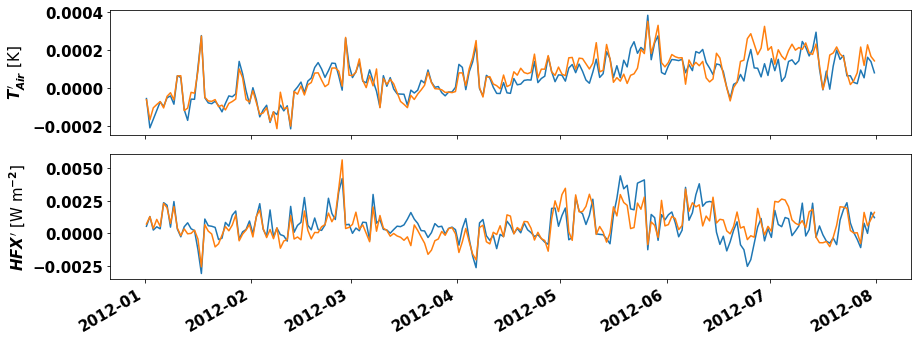

In [34]:
plt.figure(figsize=(13,5))
plt.subplot(2,1,1)

t2_fp[:,30:-30,30:200].mean(axis=1).mean(axis=1).plot()
t2_tp[:,30:-30,30:200].mean(axis=1).mean(axis=1).plot()


# t2_fp[:,190,150].plot()
# t2_tp[:,190,150].plot()
plt.xlabel('')
plt.ylabel('$T^{\prime}_{Air}$ [K]')
plt.tick_params(axis='x',labelbottom=False)

plt.subplot(2,1,2)

h_fp[:,30:-30,30:200].mean(axis=1).mean(axis=1).plot()
h_tp[:,30:-30,30:200].mean(axis=1).mean(axis=1).plot()

# h_fp[:,190,150].plot()
# h_tp[:,190,150].plot()
plt.xlabel('')
plt.ylabel('$HFX^{\prime}$ [W m$^{-2}$]')





plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/1_WRF/timeseries/T_timeseries_horizontalmean.png')


#### Test - Summing filtered and prime to original curve

In [12]:
# test_s=t2_fp[:,200,150].data + t2_fg[:,200,150].data
# plt.figure(figsize=(10,8))
# plt.plot(t2_f[:,200,150].data,alpha=0.3,marker='x')
# plt.plot(t2_fp[:,200,150].data + t2_fg[:,200,150].data,alpha=0.3,marker='o')



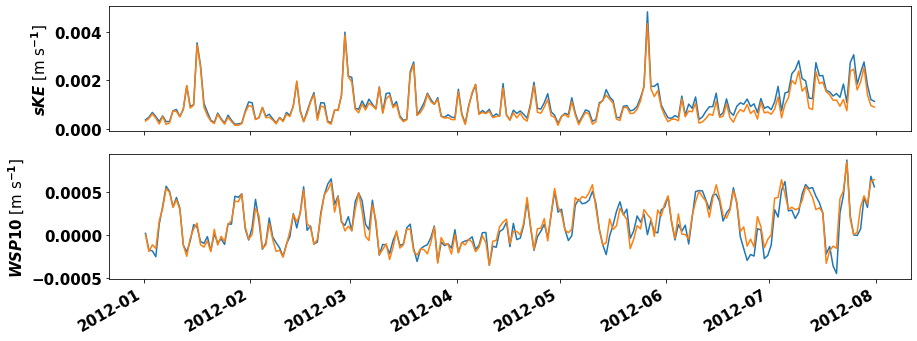

In [35]:
plt.figure(figsize=(13,5))

plt.subplot(2,1,1)

ske_fp[:,30:-30,30:200].mean(axis=1).mean(axis=1).plot()
ske_tp[:,30:-30,30:200].mean(axis=1).mean(axis=1).plot()
plt.xlabel('')
plt.ylabel('$sKE$ [m s$^{-1}$]')
plt.tick_params(axis='x',labelbottom=False)


plt.subplot(2,1,2)

w_fp[:,30:-30,30:200].mean(axis=1).mean(axis=1).plot()
w_tp[:,30:-30,30:200].mean(axis=1).mean(axis=1).plot()
plt.xlabel('')
plt.ylabel('$WSP10$ [m s$^{-1}$]')
# plt.tick_params(axis='x',labelbottom=False)

# plt.subplot(3,1,3)

# ust_fp[:,30:-30,30:200].mean(axis=1).mean(axis=1).plot()
# ust_tp[:,30:-30,30:200].mean(axis=1).mean(axis=1).plot()
# plt.xlabel('')
# plt.ylabel('$U^{*}$ [m s$^{-1}$]')
plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/1_WRF/timeseries/vel_timeseries_horizontalmean.png')

#### Central Grid-point

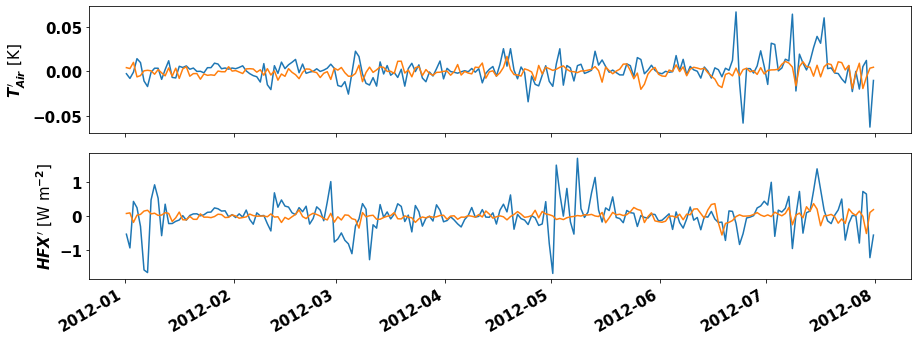

In [39]:
plt.figure(figsize=(13,5))
plt.subplot(2,1,1)

# t2_fp[:,190,150].plot()
# t2_tp[:,190,150].plot()
t2_fp[:,210,110].plot()
t2_tp[:,210,110].plot()


plt.xlabel('')
plt.ylabel('$T^{\prime}_{Air}$ [K]')
plt.tick_params(axis='x',labelbottom=False)
plt.title('')

plt.subplot(2,1,2)


h_fp[:,210,110].plot()
h_tp[:,210,110].plot()
plt.xlabel('')
plt.ylabel('$HFX^{\prime}$ [W m$^{-2}$]')
plt.title('')




plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/1_WRF/timeseries/T_timeseries_centralpoint.png')


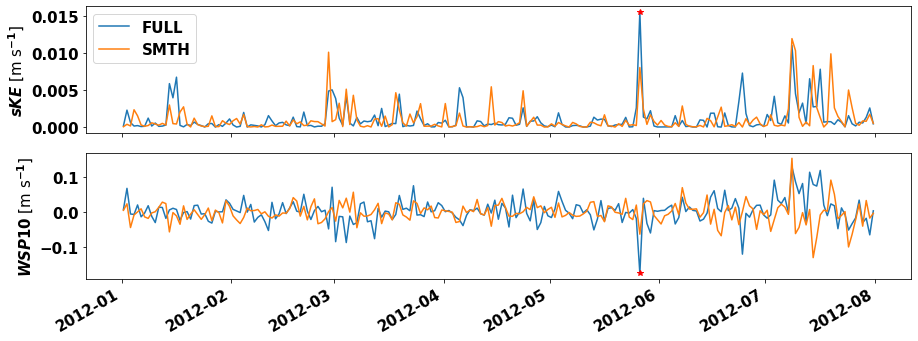

In [45]:
plt.figure(figsize=(13,5))
ipx=146
plt.subplot(2,1,1)

ske_fp[:,210,110].plot(label='FULL')
ske_tp[:,210,110].plot(label='SMTH')
plt.plot(ske_fp[ipx,210,110].time_counter,ske_fp[ipx,210,110],marker='*',color='red')
plt.xlabel('')
plt.ylabel('$sKE$ [m s$^{-1}$]')
plt.tick_params(axis='x',labelbottom=False)
plt.title('')
plt.legend()

plt.subplot(2,1,2)

w_fp[:,210,110].plot()
w_tp[:,210,110].plot()
plt.plot(w_fp[ipx,210,110].time_counter,w_fp[ipx,210,110],marker='*',color='red')

plt.xlabel('')
plt.ylabel('$WSP10$ [m s$^{-1}$]')
# plt.tick_params(axis='x',labelbottom=False)
plt.title('')


# plt.subplot(3,1,3)

# ust_fp[:,190,150].plot()
# ust_tp[:,190,150].plot()

# plt.xlabel('')
# plt.ylabel('$U^{*}$ [m s$^{-1}$]')
# plt.title('')


plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/1_WRF/timeseries/vel_timeseries_centralpoint.png')

# Horizontal Fields

#### Snapshots- Thermal

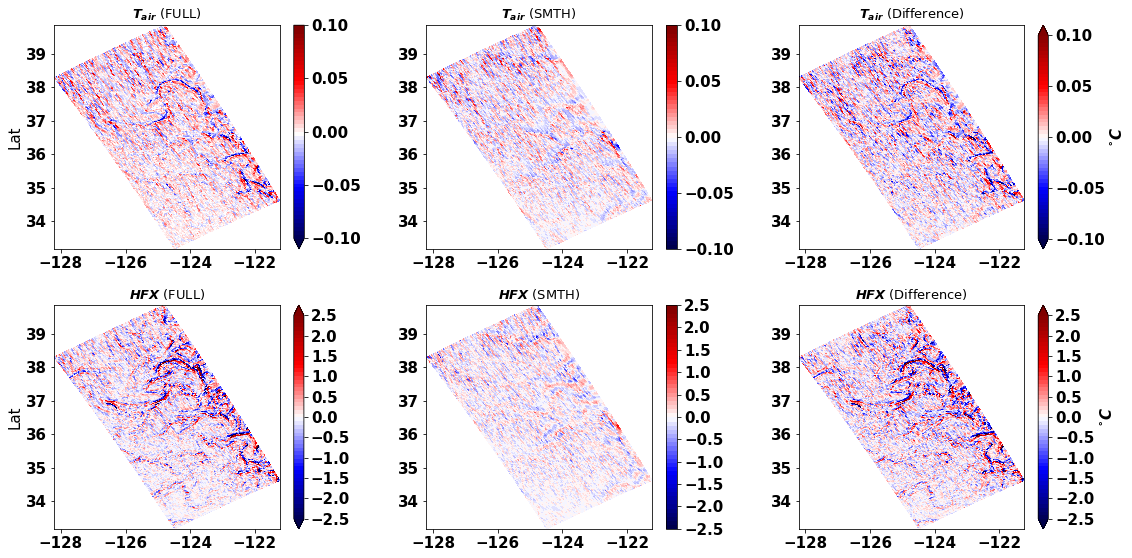

In [48]:
'temp air'

id=146
plt.figure(figsize=(16,8))

lvls=np.arange(-0.1,0.15,0.05)

plt.subplot(2,3,1)
t2_fp[id,30:-30,30:200].plot(x='nav_lon',y='nav_lat',
                             cmap='seismic',levels=np.linspace(-0.1,0.1,55),
                             cbar_kwargs={'ticks': lvls,'label':' '})
plt.title(r'$T_{air}$ (FULL)',fontsize=13)
plt.xlabel('')
plt.ylabel('Lat')

plt.subplot(2,3,2)

t2_tp[id,30:-30,30:200].plot(x='nav_lon',y='nav_lat',
                             cmap='seismic',levels=np.linspace(-0.1,0.1,55),
                             cbar_kwargs={'ticks': lvls,'label':' '})
plt.title(r'$T_{air}$ (SMTH)',fontsize=13)

plt.xlabel('')
plt.ylabel('')


plt.subplot(2,3,3)

diff=t2_fp[id,30:-30,30:200]-t2_tp[id,30:-30,30:200]


diff.plot(x='nav_lon',y='nav_lat',
                             cmap='seismic',levels=np.linspace(-0.1,0.1,55),
          cbar_kwargs={'ticks': lvls,'label':r'$^{\circ}C $'})
plt.title(r'$T_{air}$ (Difference)',fontsize=13)

plt.xlabel('')
plt.ylabel('')


'heatflux'
lvls2=np.arange(-2.5,3,0.5)

plt.subplot(2,3,4)
h_fp[id,30:-30,30:200].plot(x='nav_lon',y='nav_lat',
                             cmap='seismic',levels=np.linspace(-2.5,2.5,55),
                             cbar_kwargs={'ticks': lvls2,'label':' '})
plt.title(r'$HFX$ (FULL)',fontsize=13)
plt.xlabel('')
plt.ylabel('Lat')

plt.subplot(2,3,5)

h_tp[id,30:-30,30:200].plot(x='nav_lon',y='nav_lat',
                             cmap='seismic',levels=np.linspace(-2.5,2.5,55),
                             cbar_kwargs={'ticks': lvls2,'label':' '})
plt.title(r'$HFX$ (SMTH)',fontsize=13)

plt.xlabel('')
plt.ylabel('')


plt.subplot(2,3,6)
diff2=h_fp[id,30:-30,30:200]-h_tp[id,30:-30,30:200]

diff2.plot(x='nav_lon',y='nav_lat',
                             cmap='seismic',levels=np.linspace(-2.5,2.5,55),
          cbar_kwargs={'ticks': lvls2,'label':r'$^{\circ}C $'})
plt.title(r'$HFX$ (Difference)',fontsize=13)

plt.xlabel('')
plt.ylabel('')




plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/1_WRF/timeseries/T_snapshot_horizontalmap_day{0}.png'.format(pd.DatetimeIndex(varf.time_centered)[id]))

#### Velocity/Energy

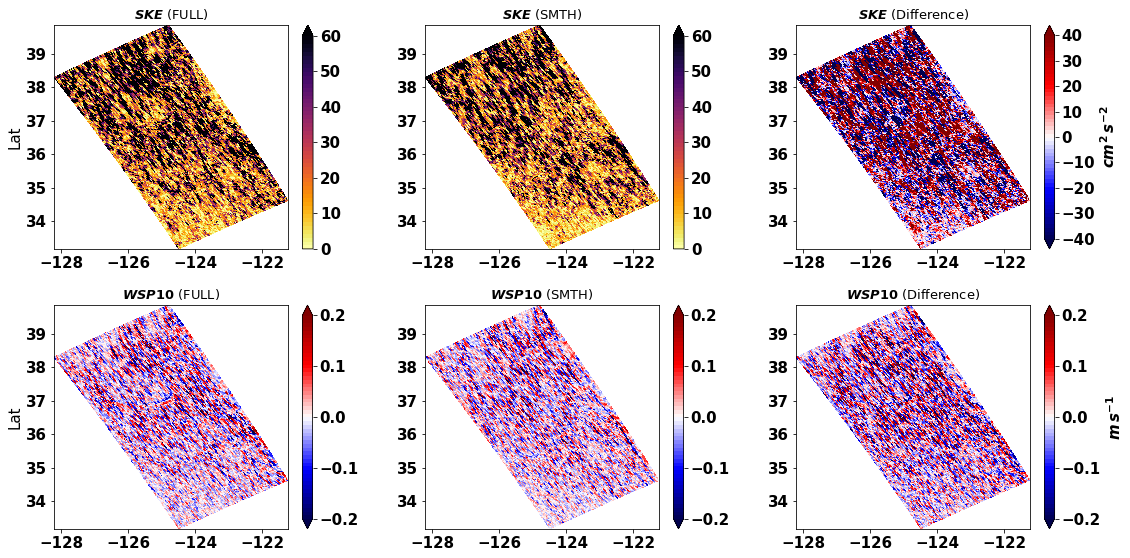

In [49]:
'ke'

id=146
plt.figure(figsize=(16,8))

lvls=np.arange(0,80,10)

plt.subplot(2,3,1)
(ske_fp[id,30:-30,30:200]*1e4).plot(x='nav_lon',y='nav_lat',
                             cmap='inferno_r',levels=np.linspace(0,60,55),
                             cbar_kwargs={'ticks': lvls,'label':' '})
plt.title(r'$SKE$ (FULL)',fontsize=13)
plt.xlabel('')
plt.ylabel('Lat')

plt.subplot(2,3,2)

(ske_tp[id,30:-30,30:200]*1e4).plot(x='nav_lon',y='nav_lat',
                             cmap='inferno_r',levels=np.linspace(0,60,55),
                             cbar_kwargs={'ticks': lvls,'label':' '})
plt.title(r'$SKE$ (SMTH)',fontsize=13)

plt.xlabel('')
plt.ylabel('')


plt.subplot(2,3,3)

diff=(ske_fp[id,30:-30,30:200]-ske_tp[id,30:-30,30:200])*1e4


diff.plot(x='nav_lon',y='nav_lat',
                             cmap='seismic',levels=np.linspace(-40,40,55),
          cbar_kwargs={'ticks':np.arange(-40,50,10),'label':r'$cm^2 \,s^{-2} $'})
plt.title(r'$SKE$ (Difference)',fontsize=13)

plt.xlabel('')
plt.ylabel('')


'windspeed'
lvls2=np.arange(-0.2,0.3,0.1)

plt.subplot(2,3,4)
w_fp[id,30:-30,30:200].plot(x='nav_lon',y='nav_lat',
                             cmap='seismic',levels=np.linspace(-0.2,0.2,55),
                             cbar_kwargs={'ticks':lvls2,'label':' '})
plt.title(r'$WSP10$ (FULL)',fontsize=13)
plt.xlabel('')
plt.ylabel('Lat')

plt.subplot(2,3,5)

w_tp[id,30:-30,30:200].plot(x='nav_lon',y='nav_lat',
                             cmap='seismic',levels=np.linspace(-0.2,0.2,55),
                             cbar_kwargs={'ticks':lvls2,'label':' '})
plt.title(r'$WSP10$ (SMTH)',fontsize=13)

plt.xlabel('')
plt.ylabel('')


plt.subplot(2,3,6)
diff2=w_fp[id,30:-30,30:200]-w_tp[id,30:-30,30:200]

diff2.plot(x='nav_lon',y='nav_lat',
                             cmap='seismic',levels=np.linspace(-0.2,0.2,55),
          cbar_kwargs={'ticks':lvls2,'label':r'$m \,s^{-1} $'})
plt.title(r'$WSP10$ (Difference)',fontsize=13)

plt.xlabel('')
plt.ylabel('')



plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/1_WRF/timeseries/vel_snapshot_horizontalmap.png_day_{0}.png'.format(pd.DatetimeIndex(varf.time_centered)[id]))

In [84]:
chunk={'time_counter':20}
path='/data/pacific/lrenault/SASI/FULL/WRF/'
listF=glob(path+'*wrfout_*.nc');listF.sort()
varF=xr.open_mfdataset(listF[-7:],chunks=chunk)


path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listT=glob(path+'*wrfout_*.nc');listT.sort()
varT=xr.open_mfdataset(listT[2:],chunks=chunk)

#### PBL

In [100]:
(pbdiff/pbmean).mean(axis=0).compute().max()*100

<xarray.DataArray 'PBLH' ()>
array(5.77575117)

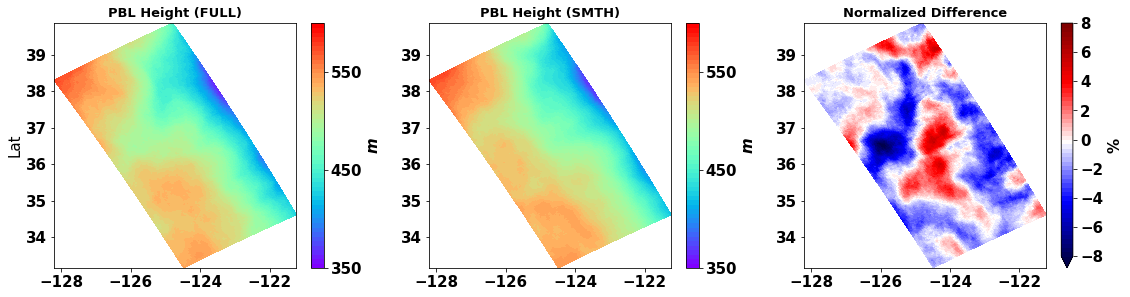

In [107]:
plt.figure(figsize=(16,8))

lvls=np.arange(350,750,100)

plt.subplot(2,3,1)
varF.PBLH[:,30:-30,30:200].mean(axis=0).plot(x='nav_lon_grid_M',y='nav_lat_grid_M',
                             cmap='rainbow',levels=np.linspace(350,600,55),
                             cbar_kwargs={'ticks': lvls,'label':r'$m$'})

plt.title(r'PBL Height (FULL)',fontsize=13,fontweight='bold')
plt.xlabel('')
plt.ylabel('Lat')

plt.subplot(2,3,2)

varT.PBLH[:,30:-30,30:200].mean(axis=0).plot(x='nav_lon_grid_M',y='nav_lat_grid_M',
                             cmap='rainbow',levels=np.linspace(350,600,55),
                             cbar_kwargs={'ticks': lvls,'label':r'$m$'})
plt.title(r'PBL Height (SMTH)',fontsize=13,fontweight='bold')

plt.xlabel('')
plt.ylabel('')


plt.subplot(2,3,3)
pbdiff=varF.PBLH[:,30:-30,30:200]-varT.PBLH[:,30:-30,30:200]
pbmean=0.5*(varF.PBLH[:,30:-30,30:200]+varT.PBLH[:,30:-30,30:200])


# (varF.PBLH[:,30:-30,30:200]-varT.PBLH[:,30:-30,30:200]).mean(axis=0).plot(x='nav_lon_grid_M',y='nav_lat_grid_M',
#                              cmap='seismic',levels=np.linspace(-60,60,55),
#           cbar_kwargs={'ticks':np.arange(-60,80,20),'label':r'$m$'})
((pbdiff/pbmean)*100).mean(axis=0).plot(x='nav_lon_grid_M',y='nav_lat_grid_M',
                     cmap='seismic',levels=np.linspace(-8,8,55),
                     cbar_kwargs={'ticks':np.arange(-8,10,2),'label':r'$\%$'})

plt.title(r'Normalized Difference',fontsize=13,fontweight='bold')

plt.xlabel('')
plt.ylabel('')
plt.tight_layout()


plt.savefig('/homes/metogra/iufarias/Documents/figures/1_WRF/timeseries/PBL_difference_horizontal_map.png')

### Investigation on total fields

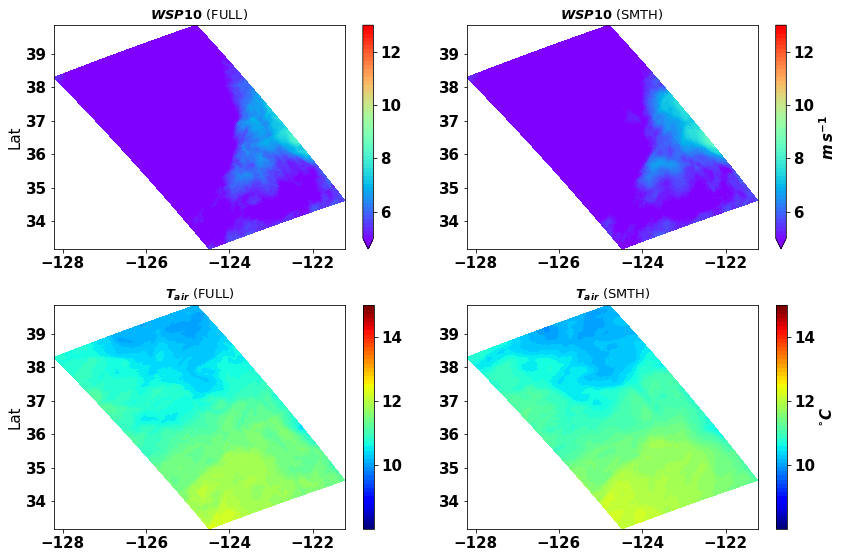

In [81]:
'ke'

id=100
plt.figure(figsize=(12,8))


plt.subplot(2,2,1)
(w_fp[id,30:-30,30:200]+w_fg[id,30:-30,30:200]).plot(x='nav_lon',y='nav_lat',
                             cmap='rainbow',levels=np.linspace(5,13,55),
                             cbar_kwargs={'ticks': lvls,'label':' '})
plt.title(r'$WSP10$ (FULL)',fontsize=13)
plt.xlabel('')
plt.ylabel('Lat')

plt.subplot(2,2,2)

(w_tp[id,30:-30,30:200]+w_tg[id,30:-30,30:200]).plot(x='nav_lon',y='nav_lat',
                             cmap='rainbow',levels=np.linspace(5,13,55),
                             cbar_kwargs={'ticks': lvls,'label':r'$m\,s^{-1}$'})
plt.title(r'$WSP10$ (SMTH)',fontsize=13)

plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

lvls2=np.arange(10,17,2)


plt.subplot(2,2,3)
((t2_fp[id,30:-30,30:200]+t2_fg[id,30:-30,30:200])-273.5).plot(x='nav_lon',y='nav_lat',
                             cmap='jet',levels=np.linspace(8,15,55),
                             cbar_kwargs={'ticks': lvls2,'label':' '})
plt.title(r'$T_{air}$ (FULL)',fontsize=13)
plt.xlabel('')
plt.ylabel('Lat')

plt.subplot(2,2,4)

((t2_tp[id,30:-30,30:200]+t2_tg[id,30:-30,30:200])-273.5).plot(x='nav_lon',y='nav_lat',
                             cmap='jet',levels=np.linspace(8,15,55),
                             cbar_kwargs={'ticks': lvls2,'label':r'$^{\circ}C$'})
plt.title(r'$T_{air}$ (SMTH)',fontsize=13)

plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/1_WRF/timeseries/test_fullvariables_wsp_tair_{0}.png'.format(pd.DatetimeIndex(varf.time_centered)[id]))

In [55]:
(t2_tp[id,30:-30,30:200]+t2_tg[id,30:-30,30:200]).compute().min()

<xarray.DataArray 'T2' ()>
array(283.86996, dtype=float32)
Coordinates:
    time_centered  datetime64[ns] 2012-07-13T12:00:00
    time_counter   datetime64[ns] 2012-07-13T12:00:00